# 1. Importing libraries.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler 

from catboost import CatBoostClassifier
from tqdm import tqdm


%matplotlib inline

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 2. Exploratory data analysis

## Train dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")

In [4]:
print("the amount of rows and columns uploaded for train_df: ", train_df.shape )

the amount of rows and columns uploaded for train_df:  (891, 12)


In [5]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


([<matplotlib.axis.XTick at 0x7f1ba6d06850>,
 [Text(0, 0, ''), Text(0, 0, '')])

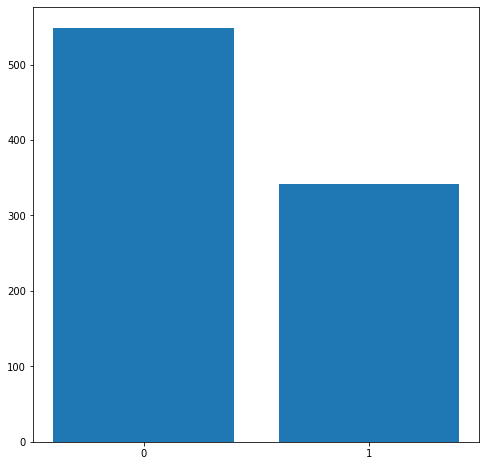

In [7]:
# Let's see the distribution of data in Survived column
fig = plt.figure(figsize=(8,8))

names = train_df["Survived"].unique()
values = train_df.groupby("Survived").size().values
plt.bar(names, values)
plt.xticks(names)

We see that the data is unbalanced a little bit

In [8]:
train_df.isnull().sum() # let's look on the missing values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

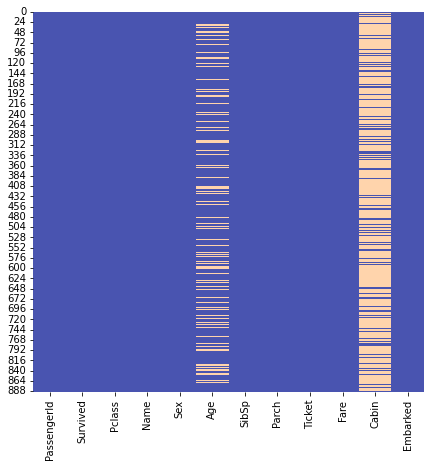

In [9]:
fig, ax = plt.subplots(figsize=(7,7))  # let's plot the distribution of missing values                 
sns.heatmap(train_df.isnull(), center=0.3, cbar=False)

**Let's look at the correlation between our variables in the data.**

<AxesSubplot:>

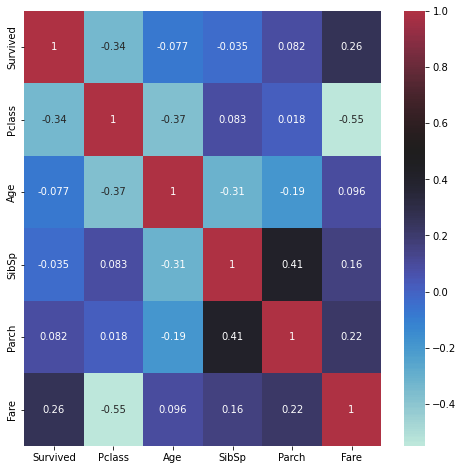

In [10]:
fig, ax = plt.subplots(figsize=(8,8))             
sns.heatmap(train_df.drop("PassengerId", axis=1).corr(method="pearson"), center=0.5, annot=True)

<AxesSubplot:>

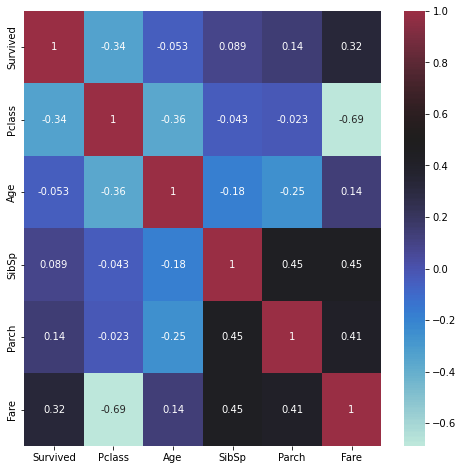

In [11]:
fig, ax = plt.subplots(figsize=(8,8))             
sns.heatmap(train_df.drop("PassengerId", axis=1).corr(method="spearman"), center=0.5, annot=True)

**We see that two types of calculating correlation coefficient gives us sliglty different results. Overall, the spearman coefficient is more for every variable by the same value. But for some variables like SibSp-Fare, the difference between two coefficients is larger than for other pairs.**

**Let's look at the number of survived and non-survived people based on class and gender.**

In [12]:
sur_data = train_df[train_df["Survived"]==1]      
no_sur_data = train_df[train_df["Survived"]==0]   

sur_gender = sur_data.groupby("Sex").size().values 
no_sur_gender = no_sur_data.groupby("Sex").size().values

genders = ["Female", "Male"]



# percentage of women survived
percentage_female_sur = sur_data.groupby("Sex").size().values[0] / (no_sur_data.groupby("Sex").size().values[0] + sur_data.groupby("Sex").size().values[0]) * 100
percentage_female_no_sur = 100 - percentage_female_sur

# percentage of men survived
percentage_male_sur = sur_data.groupby("Sex").size().values[1] / (no_sur_data.groupby("Sex").size().values[1] + sur_data.groupby("Sex").size().values[1]) * 100
percentage_male_no_sur = 100 - percentage_male_sur

# the list of all percentage survived and non-survived people by gender
percentage_gender = [percentage_female_sur, percentage_male_sur, percentage_female_no_sur, percentage_male_no_sur]



In [13]:
print("the number of survived people from 1st class - ", sur_data.groupby("Pclass").size().values[0])
print("the number of survived people from 1st class - ", sur_data.groupby("Pclass").size().values[1])
print("the number of survived people from 1st class - ", sur_data.groupby("Pclass").size().values[2])

the number of survived people from 1st class -  136
the number of survived people from 1st class -  87
the number of survived people from 1st class -  119


In [14]:
first_cl_sur = sur_data.groupby("Pclass").size().values[0]
first_cl_no_sur = no_sur_class = no_sur_data.groupby("Pclass").size().values[0]
first_sur_percent = first_cl_sur / (first_cl_sur + first_cl_no_sur) * 100
first_no_sur_percent = first_cl_no_sur / (first_cl_sur + first_cl_no_sur) * 100

sec_cl_sur = sur_data.groupby("Pclass").size().values[1]
sec_cl_no_sur = no_sur_class = no_sur_data.groupby("Pclass").size().values[1]
sec_sur_percent = sec_cl_sur / (sec_cl_sur + sec_cl_no_sur) * 100
sec_no_sur_percent = sec_cl_no_sur / (sec_cl_sur + sec_cl_no_sur) * 100

third_cl_sur = sur_data.groupby("Pclass").size().values[2]
third_cl_no_sur = no_sur_class = no_sur_data.groupby("Pclass").size().values[2]
third_sur_percent = third_cl_sur / (third_cl_sur + third_cl_no_sur) * 100
third_no_sur_percent = third_cl_no_sur / (third_cl_sur + third_cl_no_sur) * 100

percentage_class = [first_sur_percent, sec_sur_percent, third_sur_percent, first_no_sur_percent, sec_no_sur_percent, third_no_sur_percent]

In [15]:
print("the number of survived people from 1st class - ", no_sur_data.groupby("Pclass").size().values[0])
print("the number of survived people from 1st class - ", no_sur_data.groupby("Pclass").size().values[1])
print("the number of survived people from 1st class - ", no_sur_data.groupby("Pclass").size().values[2])

the number of survived people from 1st class -  80
the number of survived people from 1st class -  97
the number of survived people from 1st class -  372


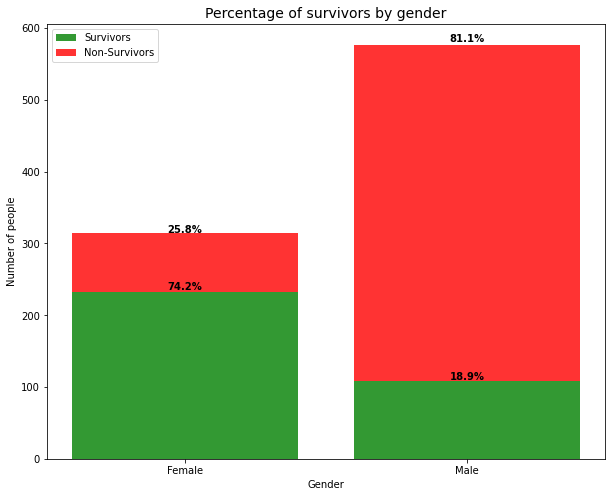

In [16]:
# vizualize the percentage of survived people by gender
f, ax = plt.subplots(1, figsize=(10,8))
ax.bar(range(len(sur_gender)), sur_gender, label='Survivors', alpha=0.8, color='g')
ax.bar(range(len(no_sur_gender)), no_sur_gender, bottom=sur_gender, label='Non-Survivors', alpha=0.8, color='r')
plt.sca(ax)
plt.xticks([0, 1], genders )
ax.set_ylabel("Number of people")
ax.set_xlabel("Gender")
ax.set_title("Percentage of survivors by gender",fontsize=14)
plt.legend(loc='upper left')

i = 0 
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    
    plt.text(x+width/2, 
            y+height*1.01, 
            str(round(percentage_gender[i], 1)) + "%",
            ha="center",
            weight='bold')
    i += 1



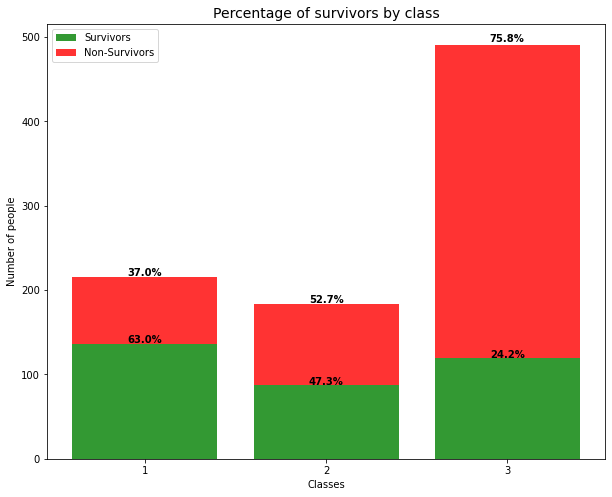

In [17]:
# vizualize the percentage of survived people by class
sur_class = sur_data.groupby("Pclass").size().values
no_sur_class = no_sur_data.groupby("Pclass").size().values
classes = [1, 2, 3]

f, ax = plt.subplots(1, figsize=(10,8))
ax.bar(range(len(sur_class)), sur_class, label='Survivors', alpha=0.8, color='g')
ax.bar(range(len(no_sur_class)), no_sur_class, bottom=sur_class, label='Non-Survivors', alpha=0.8, color='r')
plt.sca(ax)
plt.xticks([0, 1, 2], classes)
ax.set_ylabel("Number of people")
ax.set_xlabel("Classes")
ax.set_title("Percentage of survivors by class",fontsize=14)
plt.legend(loc='upper left')

i = 0 
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    
    plt.text(x+width/2, 
            y+height*1.01, 
            str(round(percentage_class[i], 1)) + "%",
            ha="center",
            weight='bold')
    i += 1



**It's perfectly seen that the number of survivors is depent on the gender and class.**

<AxesSubplot:>

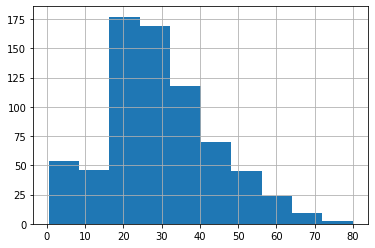

In [18]:
# As it's important to fill blanks in the "Age" column let's look at the distribution
train_df["Age"].hist()

Text(0.5, 1.0, '3')

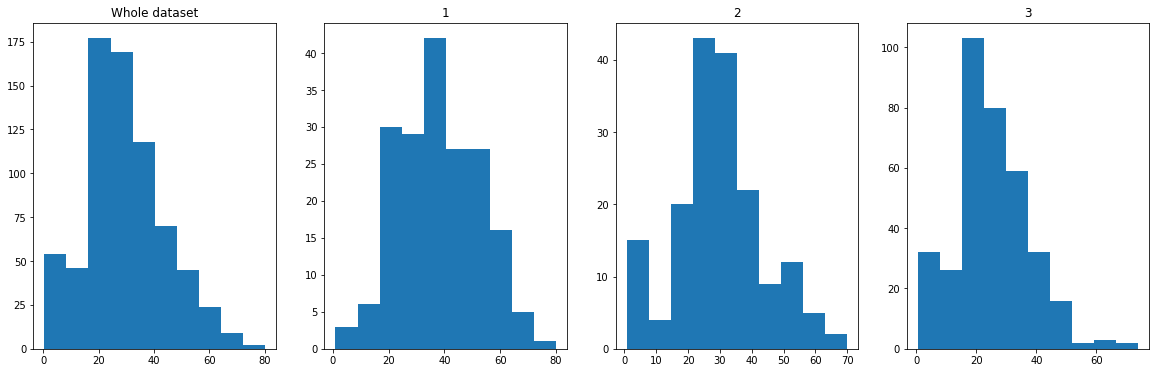

In [19]:
figure, axis = plt.subplots(1, 4, figsize=(20, 6))

# Age with respect to the whole dataset
axis[0].hist(train_df["Age"])
axis[0].set_title("Whole dataset")

# with respect to 1st class
axis[1].hist(train_df[train_df["Pclass"] == 1]["Age"])
axis[1].set_title("1")

# with respect to 2nd class
axis[2].hist(train_df[train_df["Pclass"] == 2]["Age"])
axis[2].set_title("2")

# with respect to 3nd class
axis[3].hist(train_df[train_df["Pclass"] == 3]["Age"])
axis[3].set_title("3")

**We see that the distribution of age is different with respect to the class.**

**Let's check the distribution based on gender**

Text(0.5, 1.0, 'Women')

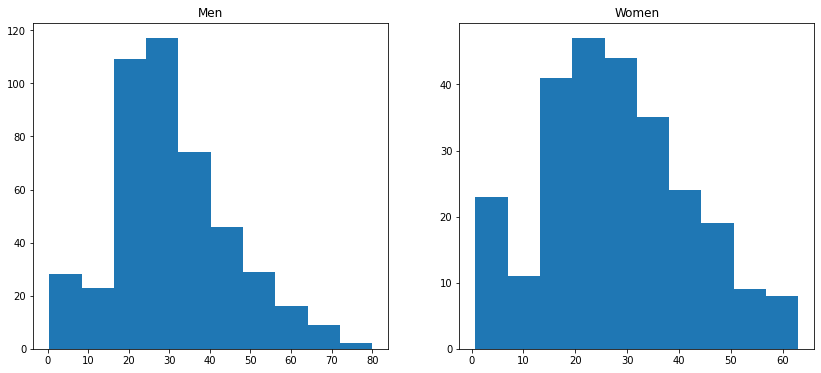

In [20]:
figure, axis = plt.subplots(1, 2, figsize=(14, 6))

# with respect to 1st class
axis[0].hist(train_df[train_df["Sex"] == "male"]["Age"])
axis[0].set_title("Men")

# with respect to 2nd class
axis[1].hist(train_df[train_df["Sex"] == "female"]["Age"])
axis[1].set_title("Women")

**We see that the distribution of age differs with respect to gender**

**Let's see the median values of age for class and gender**

In [21]:
train_df.groupby(["Pclass", "Sex"])["Age"].median()

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

## Test dataset

In [22]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [23]:
print("the amount of rows and columns uploaded for train_df: ", test_df.shape )

the amount of rows and columns uploaded for train_df:  (418, 11)


In [24]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [26]:
test_df.isnull().sum() # let's look on the missing values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Let's unite train and test dataframes in order to do preprocessing for them at once

In [27]:
final_train_df = pd.concat([train_df,test_df],keys=[0,1])
final_train_df.head()

PassengerId  Survived  Pclass  \
0 0            1       0.0       3   
  1            2       1.0       1   
  2            3       1.0       3   
  3            4       1.0       1   
  4            5       0.0       3   

                                                  Name     Sex   Age  SibSp  \
0 0                            Braund, Mr. Owen Harris    male  22.0      1   
  1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
  2                             Heikkinen, Miss. Laina  female  26.0      0   
  3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
  4                           Allen, Mr. William Henry    male  35.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0 0      0         A/5 21171   7.2500   NaN        S  
  1      0          PC 17599  71.2833   C85        C  
  2      0  STON/O2. 3101282   7.9250   NaN        S  
  3      0            113803  53.1000  C123        S  
  4      0            373450   8.0500   NaN        S

In [28]:
final_train_df.tail()

PassengerId  Survived  Pclass                          Name     Sex  \
1 413         1305       NaN       3            Spector, Mr. Woolf    male   
  414         1306       NaN       1  Oliva y Ocana, Dona. Fermina  female   
  415         1307       NaN       3  Saether, Mr. Simon Sivertsen    male   
  416         1308       NaN       3           Ware, Mr. Frederick    male   
  417         1309       NaN       3      Peter, Master. Michael J    male   

        Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
1 413   NaN      0      0           A.5. 3236    8.0500   NaN        S  
  414  39.0      0      0            PC 17758  108.9000  C105        C  
  415  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
  416   NaN      0      0              359309    8.0500   NaN        S  
  417   NaN      1      1                2668   22.3583   NaN        C

# 3. Feature engineering and data Cleaning

In [29]:
# Let's extract 'title' frome the name. It can tell us about the socio-economic status of a person
final_train_df["Title"] = final_train_df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
final_train_df.head()

PassengerId  Survived  Pclass  \
0 0            1       0.0       3   
  1            2       1.0       1   
  2            3       1.0       3   
  3            4       1.0       1   
  4            5       0.0       3   

                                                  Name     Sex   Age  SibSp  \
0 0                            Braund, Mr. Owen Harris    male  22.0      1   
  1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
  2                             Heikkinen, Miss. Laina  female  26.0      0   
  3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
  4                           Allen, Mr. William Henry    male  35.0      0   

     Parch            Ticket     Fare Cabin Embarked Title  
0 0      0         A/5 21171   7.2500   NaN        S    Mr  
  1      0          PC 17599  71.2833   C85        C   Mrs  
  2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
  3      0            113803  53.1000  C123        S   Mrs  
  4      0            373450   8.0500   NaN        S    Mr

In [30]:
final_train_df["Title"].nunique()

18

In [31]:
final_train_df["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [32]:
# There are quite few titles in the dataset. I'll consider only titles with 10 or more appearances

# check each title if it has 10 appearances(True) or not(False)
title_names = (final_train_df["Title"].value_counts() < 10)

# name the titles with less than 10 appearances to title "other"
final_train_df["Title"] = final_train_df["Title"].apply(lambda x: "other" if title_names.loc[x] == True else x)
final_train_df.head()

PassengerId  Survived  Pclass  \
0 0            1       0.0       3   
  1            2       1.0       1   
  2            3       1.0       3   
  3            4       1.0       1   
  4            5       0.0       3   

                                                  Name     Sex   Age  SibSp  \
0 0                            Braund, Mr. Owen Harris    male  22.0      1   
  1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
  2                             Heikkinen, Miss. Laina  female  26.0      0   
  3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
  4                           Allen, Mr. William Henry    male  35.0      0   

     Parch            Ticket     Fare Cabin Embarked Title  
0 0      0         A/5 21171   7.2500   NaN        S    Mr  
  1      0          PC 17599  71.2833   C85        C   Mrs  
  2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
  3      0            113803  53.1000  C123        S   Mrs  
  4      0            373450   8.0500   NaN        S    Mr

In [33]:
# count the number of people of each title
final_train_df.groupby("Title")["Title"].count()

Title
Master     61
Miss      260
Mr        757
Mrs       197
other      34
Name: Title, dtype: int64

In [34]:
final_train_df[["Title", "Survived"]].groupby("Title").mean()

,Survived
Title,
Master,0.575000
Miss,0.697802
Mr,0.156673
Mrs,0.792000
other,0.444444


<AxesSubplot:xlabel='Survived', ylabel='count'>

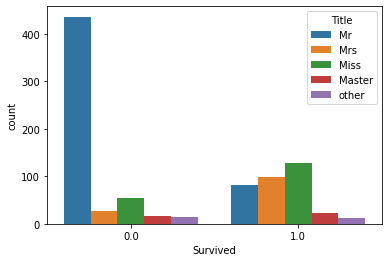

In [35]:
sns.countplot(x="Survived", hue="Title", data=final_train_df)

**We see that the ratio of survived people is more with master title and woman titles.**

### Cabin

**The cabin column carries significant information. The cabins was located on the different levels of Titanic. So the deeper level the less chances one could survive. If we look at the values in the cabin carefully we can extract a deck(the first letter) where cabin was.**

In [36]:
final_train_df["Cabin"].head()

0  0     NaN
   1     C85
   2     NaN
   3    C123
   4     NaN
Name: Cabin, dtype: object

In [37]:
final_train_df["Deck"] = final_train_df["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else "Missed")
final_train_df.head()

PassengerId  Survived  Pclass  \
0 0            1       0.0       3   
  1            2       1.0       1   
  2            3       1.0       3   
  3            4       1.0       1   
  4            5       0.0       3   

                                                  Name     Sex   Age  SibSp  \
0 0                            Braund, Mr. Owen Harris    male  22.0      1   
  1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
  2                             Heikkinen, Miss. Laina  female  26.0      0   
  3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
  4                           Allen, Mr. William Henry    male  35.0      0   

     Parch            Ticket     Fare Cabin Embarked Title    Deck  
0 0      0         A/5 21171   7.2500   NaN        S    Mr  Missed  
  1      0          PC 17599  71.2833   C85        C   Mrs       C  
  2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  Missed  
  3      0            113803  53.1000  C123        S   Mrs       C  
  4      0            373450   8.0500   NaN        S    Mr  Missed

Text(0.5, 1.0, 'Survival rates for different decks')

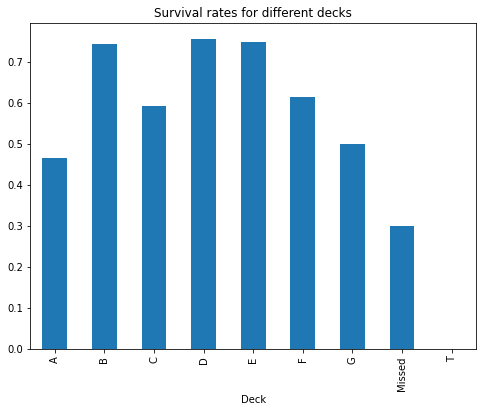

In [38]:
final_train_df[["Survived", "Deck"]].groupby("Deck")["Survived"].mean().plot(kind="bar", figsize=(8, 6))
plt.title("Survival rates for different decks")

<AxesSubplot:xlabel='Pclass', ylabel='count'>

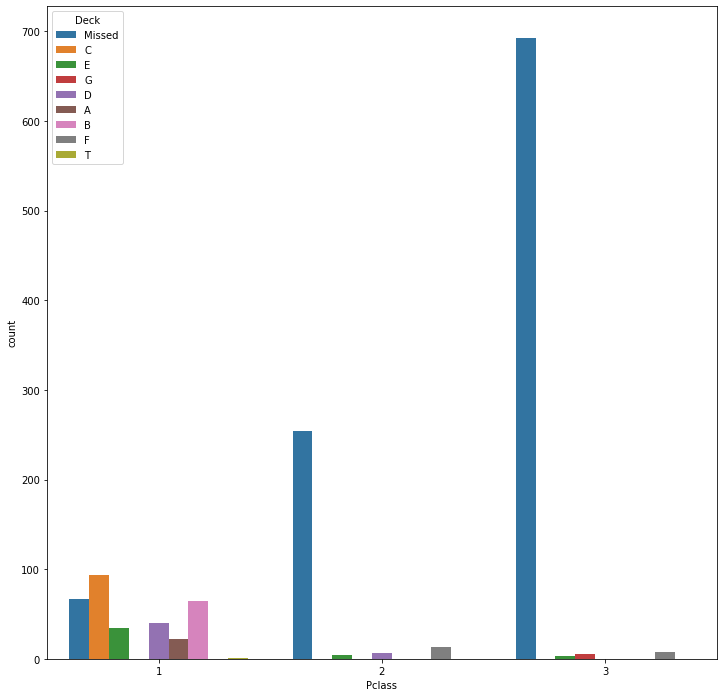

In [39]:
fig = plt.figure(figsize=(12, 12))
sns.countplot(x="Pclass", hue="Deck", data=final_train_df)

**We see that it's very hard to get a tendency in which deck the cabins of different classes were located, because even the first class cabins were located at almost every deck.**


**Delete features from the dataset which are not valuable for us. "Name" and "Cabin" are not already needed for us. Plus, we delete "PassengerId" as it is a very unique feature and delete "Fare" as in my opinion it has big correlation with "Pclass"**

In [40]:
final_train_df = final_train_df.drop(["PassengerId", "Name", "Ticket", "Cabin", "Fare"], axis=1)

In [41]:
final_train_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch Embarked Title    Deck
0 0       0.0       3    male  22.0      1      0        S    Mr  Missed
  1       1.0       1  female  38.0      1      0        C   Mrs       C
  2       1.0       3  female  26.0      0      0        S  Miss  Missed
  3       1.0       1  female  35.0      1      0        S   Mrs       C
  4       0.0       3    male  35.0      0      0        S    Mr  Missed

In [42]:
print("Количество строк в датафрейме:", len(final_train_df))

Количество строк в датафрейме: 1309


In [43]:
final_train_df.isnull().sum()

Survived    418
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Embarked      2
Title         0
Deck          0
dtype: int64

As we have only 2 missing values for Embarked column I fill the blanks with the mode.

In [44]:
final_train_df["Embarked"].mode()

0    S
dtype: object

In [45]:
final_train_df["Embarked"].fillna(final_train_df["Embarked"].mode()[0], inplace=True)


In [46]:
final_train_df.isnull().sum()

Survived    418
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Embarked      0
Title         0
Deck          0
dtype: int64

**Convert categorical features to numeric**

In [47]:
final_train_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch Embarked Title    Deck
0 0       0.0       3    male  22.0      1      0        S    Mr  Missed
  1       1.0       1  female  38.0      1      0        C   Mrs       C
  2       1.0       3  female  26.0      0      0        S  Miss  Missed
  3       1.0       1  female  35.0      1      0        S   Mrs       C
  4       0.0       3    male  35.0      0      0        S    Mr  Missed

In [48]:
# final_train_df = pd.get_dummies(final_train_df, columns=["Sex", "Embarked", "Pclass"])
final_train_df = pd.get_dummies(final_train_df, columns=["Sex", "Pclass", "Embarked", "Title", "Deck"])

In [49]:
final_train_df.head()

Survived   Age  SibSp  Parch  Sex_female  Sex_male  Pclass_1  Pclass_2  \
0 0       0.0  22.0      1      0           0         1         0         0   
  1       1.0  38.0      1      0           1         0         1         0   
  2       1.0  26.0      0      0           1         0         0         0   
  3       1.0  35.0      1      0           1         0         1         0   
  4       0.0  35.0      0      0           0         1         0         0   

     Pclass_3  Embarked_C  ...  Title_other  Deck_A  Deck_B  Deck_C  Deck_D  \
0 0         1           0  ...            0       0       0       0       0   
  1         0           1  ...            0       0       0       1       0   
  2         1           0  ...            0       0       0       0       0   
  3         0           0  ...            0       0       0       1       0   
  4         1           0  ...            0       0       0       0       0   

     Deck_E  Deck_F  Deck_G  Deck_Missed  Deck_T  
0 0       0       0       0            1       0  
  1       0       0       0            0       0  
  2       0       0       0            1       0  
  3       0       0       0            0       0  
  4       0       0       0            1       0  

[5 rows x 26 columns]

In [50]:
final_train_df = final_train_df.rename(columns={"Sex_female": "female/male"}) # в столбце female/male "0" - male, "1" - female
final_train_df.drop("Sex_male", axis=1, inplace=True)

In [51]:
final_train_df.head()

Survived   Age  SibSp  Parch  female/male  Pclass_1  Pclass_2  Pclass_3  \
0 0       0.0  22.0      1      0            0         0         0         1   
  1       1.0  38.0      1      0            1         1         0         0   
  2       1.0  26.0      0      0            1         0         0         1   
  3       1.0  35.0      1      0            1         1         0         0   
  4       0.0  35.0      0      0            0         0         0         1   

     Embarked_C  Embarked_Q  ...  Title_other  Deck_A  Deck_B  Deck_C  Deck_D  \
0 0           0           0  ...            0       0       0       0       0   
  1           1           0  ...            0       0       0       1       0   
  2           0           0  ...            0       0       0       0       0   
  3           0           0  ...            0       0       0       1       0   
  4           0           0  ...            0       0       0       0       0   

     Deck_E  Deck_F  Deck_G  Deck_Missed  Deck_T  
0 0       0       0       0            1       0  
  1       0       0       0            0       0  
  2       0       0       0            1       0  
  3       0       0       0            0       0  
  4       0       0       0            1       0  

[5 rows x 25 columns]

**Сonvert "SibSp" и "Parch" into "Family_size" features in order to distinguish people who was alone from those who was with the family. If the value is greater than 1 it mean that a person was with family, if equal 1 - alone.**

In [52]:
final_train_df["Family_size"] = final_train_df["SibSp"] + final_train_df["Parch"] + 1

In [53]:
final_train_df.head()

Survived   Age  SibSp  Parch  female/male  Pclass_1  Pclass_2  Pclass_3  \
0 0       0.0  22.0      1      0            0         0         0         1   
  1       1.0  38.0      1      0            1         1         0         0   
  2       1.0  26.0      0      0            1         0         0         1   
  3       1.0  35.0      1      0            1         1         0         0   
  4       0.0  35.0      0      0            0         0         0         1   

     Embarked_C  Embarked_Q  ...  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  \
0 0           0           0  ...       0       0       0       0       0   
  1           1           0  ...       0       0       1       0       0   
  2           0           0  ...       0       0       0       0       0   
  3           0           0  ...       0       0       1       0       0   
  4           0           0  ...       0       0       0       0       0   

     Deck_F  Deck_G  Deck_Missed  Deck_T  Family_size  
0 0       0       0            1       0            2  
  1       0       0            0       0            2  
  2       0       0            1       0            1  
  3       0       0            0       0            2  
  4       0       0            1       0            1  

[5 rows x 26 columns]

<!-- Create the column "Is_alone" based on "Family_size" -->

**Create the column "Is_alone" which corresponds whether a person was alone or not**

In [54]:
final_train_df["Is_alone"] = 1 

In [55]:
final_train_df.loc[final_train_df.Family_size > 1, "Is_alone"] = 0

In [56]:
final_train_df = final_train_df.drop(["Family_size", "SibSp", "Parch"], axis=1)

In [57]:
final_train_df.head(3)

Survived   Age  female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  \
0 0       0.0  22.0            0         0         0         1           0   
  1       1.0  38.0            1         1         0         0           1   
  2       1.0  26.0            1         0         0         1           0   

     Embarked_Q  Embarked_S  Title_Master  ...  Deck_A  Deck_B  Deck_C  \
0 0           0           1             0  ...       0       0       0   
  1           0           0             0  ...       0       0       1   
  2           0           1             0  ...       0       0       0   

     Deck_D  Deck_E  Deck_F  Deck_G  Deck_Missed  Deck_T  Is_alone  
0 0       0       0       0       0            1       0         0  
  1       0       0       0       0            0       0         0  
  2       0       0       0       0            1       0         1  

[3 rows x 24 columns]

### Clustering for filling Nans

**We fill the missing values in "Age" by using cluster analysis. You can check this [notebook](https://www.kaggle.com/code/alexeyshakov/titanic) for more information**

In [58]:
final_train_df_cluster = final_train_df.copy()
final_train_df_cluster.head()

Survived   Age  female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  \
0 0       0.0  22.0            0         0         0         1           0   
  1       1.0  38.0            1         1         0         0           1   
  2       1.0  26.0            1         0         0         1           0   
  3       1.0  35.0            1         1         0         0           0   
  4       0.0  35.0            0         0         0         1           0   

     Embarked_Q  Embarked_S  Title_Master  ...  Deck_A  Deck_B  Deck_C  \
0 0           0           1             0  ...       0       0       0   
  1           0           0             0  ...       0       0       1   
  2           0           1             0  ...       0       0       0   
  3           0           1             0  ...       0       0       1   
  4           0           1             0  ...       0       0       0   

     Deck_D  Deck_E  Deck_F  Deck_G  Deck_Missed  Deck_T  Is_alone  
0 0       0       0       0       0            1       0         0  
  1       0       0       0       0            0       0         0  
  2       0       0       0       0            1       0         1  
  3       0       0       0       0            0       0         0  
  4       0       0       0       0            1       0         1  

[5 rows x 24 columns]

In [59]:
final_train_df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (0, 0) to (1, 417)
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Age           1046 non-null   float64
 2   female/male   1309 non-null   uint8  
 3   Pclass_1      1309 non-null   uint8  
 4   Pclass_2      1309 non-null   uint8  
 5   Pclass_3      1309 non-null   uint8  
 6   Embarked_C    1309 non-null   uint8  
 7   Embarked_Q    1309 non-null   uint8  
 8   Embarked_S    1309 non-null   uint8  
 9   Title_Master  1309 non-null   uint8  
 10  Title_Miss    1309 non-null   uint8  
 11  Title_Mr      1309 non-null   uint8  
 12  Title_Mrs     1309 non-null   uint8  
 13  Title_other   1309 non-null   uint8  
 14  Deck_A        1309 non-null   uint8  
 15  Deck_B        1309 non-null   uint8  
 16  Deck_C        1309 non-null   uint8  
 17  Deck_D        1309 non-null   uint8  
 18  Deck_E        1309 

In [60]:
# Import the whiten function
from scipy.cluster.vq import whiten

# get the columns names without 'Age'
columns_names = list(final_train_df_cluster.columns)
columns_names.remove("Age")
columns_names.remove("Survived")

# drop age columns as we'll cluster obesvations without it
final_train_df_cluster.drop(["Age", "Survived"], axis=1, inplace=True)

final_train_df_cluster.head()

female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  \
0 0            0         0         0         1           0           0   
  1            1         1         0         0           1           0   
  2            1         0         0         1           0           0   
  3            1         1         0         0           0           0   
  4            0         0         0         1           0           0   

     Embarked_S  Title_Master  Title_Miss  Title_Mr  ...  Deck_A  Deck_B  \
0 0           1             0           0         1  ...       0       0   
  1           0             0           0         0  ...       0       0   
  2           1             0           1         0  ...       0       0   
  3           1             0           0         0  ...       0       0   
  4           1             0           0         1  ...       0       0   

     Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_Missed  Deck_T  Is_alone  
0 0       0       0       0       0       0            1       0         0  
  1       1       0       0       0       0            0       0         0  
  2       0       0       0       0       0            1       0         1  
  3       1       0       0       0       0            0       0         0  
  4       0       0       0       0       0            1       0         1  

[5 rows x 22 columns]

In [61]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage

# Use the linkage() function
distance_matrix = linkage(final_train_df_cluster.to_numpy(), method = 'ward', metric = 'euclidean')

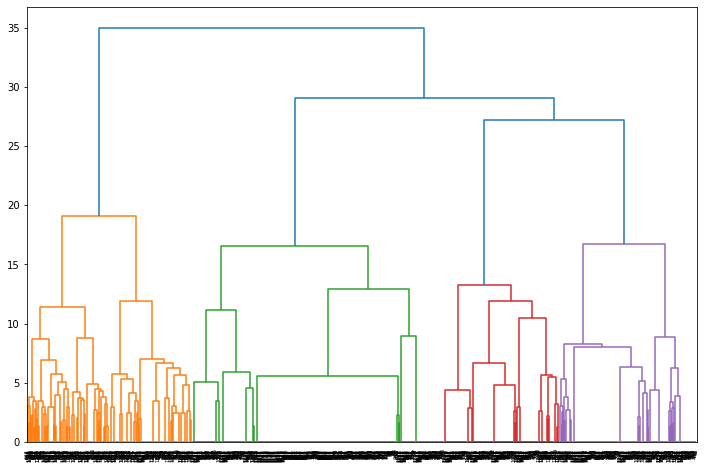

In [62]:
fig = plt.figure(figsize=(12,8))
# Import the dendrogram function
from scipy.cluster.hierarchy import dendrogram
 
# Create a dendrogram
dn = dendrogram(distance_matrix)
 
# Display the dendogram
plt.show()

In [63]:
# n_clust_hier = 3
thresh = 25

In [64]:
final_train_df_cluster["cluster_labels"] = fcluster(distance_matrix, thresh, criterion='distance')
final_train_df_cluster.head()

female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  \
0 0            0         0         0         1           0           0   
  1            1         1         0         0           1           0   
  2            1         0         0         1           0           0   
  3            1         1         0         0           0           0   
  4            0         0         0         1           0           0   

     Embarked_S  Title_Master  Title_Miss  Title_Mr  ...  Deck_B  Deck_C  \
0 0           1             0           0         1  ...       0       0   
  1           0             0           0         0  ...       0       1   
  2           1             0           1         0  ...       0       0   
  3           1             0           0         0  ...       0       1   
  4           1             0           0         1  ...       0       0   

     Deck_D  Deck_E  Deck_F  Deck_G  Deck_Missed  Deck_T  Is_alone  \
0 0       0       0       0       0            1       0         0   
  1       0       0       0       0            0       0         0   
  2       0       0       0       0            1       0         1   
  3       0       0       0       0            0       0         0   
  4       0       0       0       0            1       0         1   

     cluster_labels  
0 0               2  
  1               1  
  2               3  
  3               1  
  4               2  

[5 rows x 23 columns]

In [65]:
# add age column from the initial dataset
final_train_df_cluster = pd.concat([final_train_df_cluster, final_train_df[["Age", "Survived"]]], axis=1)
final_train_df_cluster.head()

female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  \
0 0            0         0         0         1           0           0   
  1            1         1         0         0           1           0   
  2            1         0         0         1           0           0   
  3            1         1         0         0           0           0   
  4            0         0         0         1           0           0   

     Embarked_S  Title_Master  Title_Miss  Title_Mr  ...  Deck_D  Deck_E  \
0 0           1             0           0         1  ...       0       0   
  1           0             0           0         0  ...       0       0   
  2           1             0           1         0  ...       0       0   
  3           1             0           0         0  ...       0       0   
  4           1             0           0         1  ...       0       0   

     Deck_F  Deck_G  Deck_Missed  Deck_T  Is_alone  cluster_labels   Age  \
0 0       0       0            1       0         0               2  22.0   
  1       0       0            0       0         0               1  38.0   
  2       0       0            1       0         1               3  26.0   
  3       0       0            0       0         0               1  35.0   
  4       0       0            1       0         1               2  35.0   

     Survived  
0 0       0.0  
  1       1.0  
  2       1.0  
  3       1.0  
  4       0.0  

[5 rows x 25 columns]

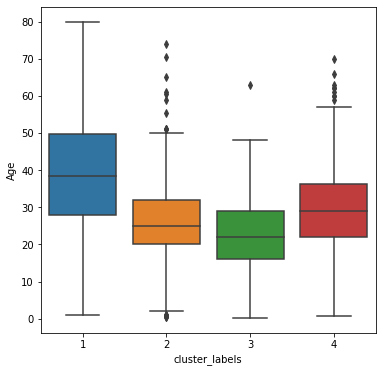

In [66]:
# let's make the boxplots for each cluster
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.boxplot(x="cluster_labels", y="Age", data=final_train_df_cluster)

In [67]:
# final_train_df_median['Age'].fillna(final_train_df.groupby(['female/male'])['Age'].transform(np.median), inplace=True)

In [68]:
# filling blanks
final_train_df_cluster['Age'].fillna(final_train_df_cluster.groupby(['cluster_labels'])['Age'].transform(np.median), inplace=True)

In [69]:
final_train_df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (0, 0) to (1, 417)
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   female/male     1309 non-null   uint8  
 1   Pclass_1        1309 non-null   uint8  
 2   Pclass_2        1309 non-null   uint8  
 3   Pclass_3        1309 non-null   uint8  
 4   Embarked_C      1309 non-null   uint8  
 5   Embarked_Q      1309 non-null   uint8  
 6   Embarked_S      1309 non-null   uint8  
 7   Title_Master    1309 non-null   uint8  
 8   Title_Miss      1309 non-null   uint8  
 9   Title_Mr        1309 non-null   uint8  
 10  Title_Mrs       1309 non-null   uint8  
 11  Title_other     1309 non-null   uint8  
 12  Deck_A          1309 non-null   uint8  
 13  Deck_B          1309 non-null   uint8  
 14  Deck_C          1309 non-null   uint8  
 15  Deck_D          1309 non-null   uint8  
 16  Deck_E          1309 non-null   uint8  
 17  Deck_F          1309 non

In [70]:
final_train_df_cluster = pd.get_dummies(data=final_train_df_cluster, columns=["cluster_labels"])
final_train_df_cluster.head()

female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  \
0 0            0         0         0         1           0           0   
  1            1         1         0         0           1           0   
  2            1         0         0         1           0           0   
  3            1         1         0         0           0           0   
  4            0         0         0         1           0           0   

     Embarked_S  Title_Master  Title_Miss  Title_Mr  ...  Deck_G  Deck_Missed  \
0 0           1             0           0         1  ...       0            1   
  1           0             0           0         0  ...       0            0   
  2           1             0           1         0  ...       0            1   
  3           1             0           0         0  ...       0            0   
  4           1             0           0         1  ...       0            1   

     Deck_T  Is_alone   Age  Survived  cluster_labels_1  cluster_labels_2  \
0 0       0         0  22.0       0.0                 0                 1   
  1       0         0  38.0       1.0                 1                 0   
  2       0         1  26.0       1.0                 0                 0   
  3       0         0  35.0       1.0                 1                 0   
  4       0         1  35.0       0.0                 0                 1   

     cluster_labels_3  cluster_labels_4  
0 0                 0                 0  
  1                 0                 0  
  2                 1                 0  
  3                 0                 0  
  4                 0                 0  

[5 rows x 28 columns]

**Let's try to group our ages.**

In [71]:
ages = final_train_df_cluster[["Age"]]
ages.head()

Age
0 0  22.0
  1  38.0
  2  26.0
  3  35.0
  4  35.0

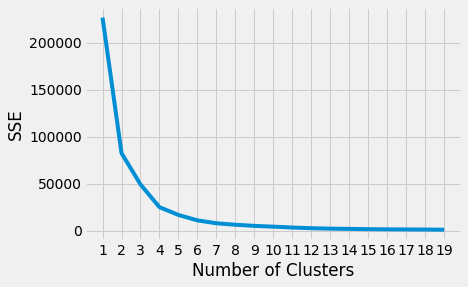

In [72]:
from sklearn.cluster import KMeans

sse = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(ages)
    sse.append(kmeans.inertia_) # inertia возвращает сумму квадратов расстояния от каждого образца до ближайшего центроида
    

plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [73]:
n_clust_age = 13

In [74]:
kmeans_best_model = KMeans(n_clusters=n_clust_age, random_state=0)
kmeans_best_model.fit(ages)

KMeans(n_clusters=13, random_state=0)

In [75]:
final_train_df_cluster["kmeans_labels"] = kmeans_best_model.labels_
final_train_df_cluster.drop("Age", axis=1, inplace=True)
final_train_df_cluster = pd.get_dummies(data=final_train_df_cluster, columns=["kmeans_labels"])

final_train_df_cluster.head()

female/male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  \
0 0            0         0         0         1           0           0   
  1            1         1         0         0           1           0   
  2            1         0         0         1           0           0   
  3            1         1         0         0           0           0   
  4            0         0         0         1           0           0   

     Embarked_S  Title_Master  Title_Miss  Title_Mr  ...  kmeans_labels_3  \
0 0           1             0           0         1  ...                0   
  1           0             0           0         0  ...                1   
  2           1             0           1         0  ...                0   
  3           1             0           0         0  ...                0   
  4           1             0           0         1  ...                0   

     kmeans_labels_4  kmeans_labels_5  kmeans_labels_6  kmeans_labels_7  \
0 0                0                0                0                0   
  1                0                0                0                0   
  2                0                0                0                0   
  3                0                0                0                0   
  4                0                0                0                0   

     kmeans_labels_8  kmeans_labels_9  kmeans_labels_10  kmeans_labels_11  \
0 0                1                0                 0                 0   
  1                0                0                 0                 0   
  2                0                0                 0                 0   
  3                0                0                 0                 1   
  4                0                0                 0                 1   

     kmeans_labels_12  
0 0                 0  
  1                 0  
  2                 0  
  3                 0  
  4                 0  

[5 rows x 40 columns]

## Split our data to train and test

In [76]:
train, test = final_train_df_cluster.xs(0),final_train_df_cluster.xs(1)

X = train.drop("Survived", axis=1)
y = train["Survived"]

ultimate_test = test.drop("Survived", axis=1)
# X_cluster = final_train_df_cluster.drop("Survived", axis=1)
# y_cluster = final_train_df_cluster["Survived"]

print(X.shape, ultimate_test.shape, "\n", y.shape)

(891, 39) (418, 39) 
 (891,)


In [77]:
X.head()

,female/male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,...,kmeans_labels_3,kmeans_labels_4,kmeans_labels_5,kmeans_labels_6,kmeans_labels_7,kmeans_labels_8,kmeans_labels_9,kmeans_labels_10,kmeans_labels_11,kmeans_labels_12
0,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [78]:
y.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [79]:
ultimate_test.head()

,female/male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,...,kmeans_labels_3,kmeans_labels_4,kmeans_labels_5,kmeans_labels_6,kmeans_labels_7,kmeans_labels_8,kmeans_labels_9,kmeans_labels_10,kmeans_labels_11,kmeans_labels_12
0,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [80]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X, y, test_size=0.2, random_state=0)

In [81]:
print(X_train_cluster.shape, X_test_cluster.shape, "\n", y_train_cluster.shape, y_test_cluster.shape)

(712, 39) (179, 39) 
 (712,) (179,)


# 4. Creating a model

## Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()

In [83]:
rf_param = {"n_estimators": [100, 200, 500],
           "max_depth": range(1, 11, 2),
           "min_samples_leaf": [10 ,30,50, 100],
           "max_features": ["sqrt", "log2"],
           "random_state": [0]}

In [84]:
%%time
grid_rd = GridSearchCV(rf_clf, rf_param, scoring='f1', cv=5, n_jobs=-1)
grid_rd.fit(X_train_cluster, y_train_cluster)

CPU times: user 3.95 s, sys: 173 ms, total: 4.13 s
Wall time: 2min 7s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 11, 2),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 30, 50, 100],
                         'n_estimators': [100, 200, 500], 'random_state': [0]},
             scoring='f1')

In [85]:
grid_rd.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'n_estimators': 100,
 'random_state': 0}

In [86]:
grid_rd.best_score_

0.7484716772773427

In [87]:
preds = grid_rd.predict(X_test_cluster)

In [88]:
print(classification_report(preds, y_test_cluster))

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       112
         1.0       0.71      0.73      0.72        67

    accuracy                           0.79       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.79      0.79      0.79       179



In [89]:
# assign found parameters to new model
best_rf = grid_rd.best_estimator_

## Catboost

In [90]:
%%time
simple_cat = CatBoostClassifier(silent=True)

simple_cat.fit(X_train_cluster, y_train_cluster)

CPU times: user 2.32 s, sys: 767 ms, total: 3.09 s
Wall time: 1.23 s


In [91]:
pred_simple_cat = simple_cat.predict(X_test_cluster)

In [92]:
print(classification_report(pred_simple_cat, y_test_cluster))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84       114
         1.0       0.71      0.75      0.73        65

    accuracy                           0.80       179
   macro avg       0.78      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



**It's seen that the result of not tuned catboost is pretty good. Let's try to tune it**

In [93]:
params_cat = [{"depth": range(6,11)},
#              {"num_trees": [100, 300, 500]},
             {"learning_rate": [1, 0.1, 0.01, 0.001]},
             {"l2_leaf_reg": [0.1, 1, 10, 100]}
             ]


In [94]:
# %%time
# grid_rd = GridSearchCV(rf_clf, rf_param, scoring='f1', cv=5, n_jobs=-1)
# grid_rd.fit(X_train_cluster, y_train_cluster)

In [95]:
%%time
best_params = dict()
for dictionary in tqdm(params_cat):
    cat = CatBoostClassifier(silent=True)
    grid_cat = GridSearchCV(cat, dictionary, scoring='f1', cv=5, n_jobs=-1)
    grid_cat.fit(X_train_cluster, y_train_cluster)
    key = list(grid_cat.best_params_.keys())[0]
    best_params[key] = grid_cat.best_params_.get(key)
    print("hyperparameter has been tuned")

 33%|███▎      | 1/3 [01:12<02:25, 72.93s/it]

hyperparameter has been tuned


 67%|██████▋   | 2/3 [01:36<00:44, 44.05s/it]

hyperparameter has been tuned


100%|██████████| 3/3 [02:00<00:00, 40.13s/it]

hyperparameter has been tuned
CPU times: user 12.8 s, sys: 3.28 s, total: 16 s
Wall time: 2min


In [96]:
best_params

{'depth': 9, 'learning_rate': 0.001, 'l2_leaf_reg': 100}

In [97]:
best_params["use_best_model"] = True
best_params["eval_metric"] = "F1"
best_params["silent"] = True
best_params["iterations"] = 1000

best_params

{'depth': 9,
 'learning_rate': 0.001,
 'l2_leaf_reg': 100,
 'use_best_model': True,
 'eval_metric': 'F1',
 'silent': True,
 'iterations': 1000}

In [98]:
# we need to cut some data for catboost
for_train_test, for_eval = train_test_split(train, test_size=0.1, random_state=0)
print(for_eval.shape)
print(for_train_test.shape)

(90, 40)
(801, 40)


In [99]:
X_cat = for_train_test.drop("Survived", axis=1)
y_cat = for_train_test["Survived"]

# get eval sets for catboost
X_eval = for_eval.drop("Survived", axis=1)
y_eval = for_eval["Survived"]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=0)

print(X_train_cat.shape, X_test_cat.shape, "\n", y_train_cat.shape, y_test_cat.shape, "\n", X_eval.shape, y_eval.shape)

(640, 39) (161, 39) 
 (640,) (161,) 
 (90, 39) (90,)


In [100]:
%%time
best_cat = CatBoostClassifier(**best_params)

best_cat.fit(X_cat, y_cat, eval_set=(X_eval, y_eval), early_stopping_rounds=150, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 515 ms, sys: 151 ms, total: 666 ms
Wall time: 337 ms


In [101]:
preds_best_cat = best_cat.predict(X_test_cat)

In [102]:
print(classification_report(preds_best_cat, y_test_cat))

              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88       120
         1.0       0.63      0.83      0.72        41

    accuracy                           0.83       161
   macro avg       0.78      0.83      0.80       161
weighted avg       0.86      0.83      0.84       161



**The result of tuned Catboost is better than of Random Forest**

### Making prediction for test data

In [103]:
ultimate_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   female/male       418 non-null    uint8
 1   Pclass_1          418 non-null    uint8
 2   Pclass_2          418 non-null    uint8
 3   Pclass_3          418 non-null    uint8
 4   Embarked_C        418 non-null    uint8
 5   Embarked_Q        418 non-null    uint8
 6   Embarked_S        418 non-null    uint8
 7   Title_Master      418 non-null    uint8
 8   Title_Miss        418 non-null    uint8
 9   Title_Mr          418 non-null    uint8
 10  Title_Mrs         418 non-null    uint8
 11  Title_other       418 non-null    uint8
 12  Deck_A            418 non-null    uint8
 13  Deck_B            418 non-null    uint8
 14  Deck_C            418 non-null    uint8
 15  Deck_D            418 non-null    uint8
 16  Deck_E            418 non-null    uint8
 17  Deck_F            418 non-null    u

In [104]:
# unite our data to train final models
united_data_X = pd.concat([X_train_cluster, X_test_cluster])
print(united_data_X.shape)
united_data_X.head()

(891, 39)


,female/male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,...,kmeans_labels_3,kmeans_labels_4,kmeans_labels_5,kmeans_labels_6,kmeans_labels_7,kmeans_labels_8,kmeans_labels_9,kmeans_labels_10,kmeans_labels_11,kmeans_labels_12
140,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
439,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
817,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
378,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
491,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [105]:
united_data_y = pd.concat([y_train_cluster, y_test_cluster])
print(united_data_y.shape)
united_data_y.head()

(891,)


140    0.0
439    0.0
817    0.0
378    0.0
491    0.0
Name: Survived, dtype: float64

In [106]:
best_rf.fit(united_data_X, united_data_y)


RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=10,
                       random_state=0)

In [107]:
# unite data for catboost
united_data_X_cat = pd.concat([X_train_cat, X_test_cat])
print(united_data_X_cat.shape)
united_data_X_cat.head()

(801, 39)


,female/male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,...,kmeans_labels_3,kmeans_labels_4,kmeans_labels_5,kmeans_labels_6,kmeans_labels_7,kmeans_labels_8,kmeans_labels_9,kmeans_labels_10,kmeans_labels_11,kmeans_labels_12
135,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
490,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
631,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
389,1,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
269,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [108]:
united_data_y = pd.concat([y_train_cat, y_test_cat])
print(united_data_y.shape)
united_data_y.head()

(801,)


135    0.0
490    0.0
631    0.0
389    1.0
269    1.0
Name: Survived, dtype: float64

In [109]:
cat_for_test = CatBoostClassifier(**best_params)

best_cat.fit(united_data_X_cat, united_data_y, eval_set=(X_eval, y_eval), early_stopping_rounds=150, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [110]:
best_prediction = best_rf.predict(ultimate_test)
# best_prediction = cat1.predict(ultimate_test)
# best_prediction = best_cat.predict(ultimate_test)

In [111]:
submission = pd.DataFrame(best_prediction).reset_index().rename(columns={"index": "PassengerId", 0: "Survived"})
right_ids = [i for i in range(892, 1310, 1)]
submission["PassengerId"] = right_ids
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [112]:
submission["Survived"] = submission["Survived"].astype(int)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [113]:
submission.to_csv('submission.csv', index = False)

In [114]:
pd.read_csv("submission.csv").head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
